In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats

## Standard Statsmodels import
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

## fixing random for lesson generation
np.random.seed(321)

## load data
df = pd.read_csv('Data/tmdb_results_combined.csv.gz')
df.head()

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,Two rural teens sing and dance their way throu...,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.500,22.0,NaN
2,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,Earth is in a state of constant war and two co...,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,5.100,8.0,NaN
3,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,"After falling prey to underworld, four friends...",...,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,4.000,1.0,NaN
4,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",http://www.wkw-inthemoodforlove.com/,843.0,cn,花樣年華,"Hong Kong, 1962: Chow Mo-Wan and Su Li-Zhen mo...",...,12854953.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.112,2009.0,PG


## Preprocessing
### Feature Engineering


 - lets convert 'belongs to collection' column to a boolean column

In [2]:
print(f"The number of unique values in 'belongs_to_collection' column is : ", df['belongs_to_collection'].nunique())
print("\nPreview of 'belongs_to_collection' column\n ", df['belongs_to_collection'].value_counts()[:5])

The number of unique values in 'belongs_to_collection' column is :  1870

Preview of 'belongs_to_collection' column
  {'id': 39199, 'name': 'Detective Conan Collection', 'poster_path': '/bV6EHK0Q65hHKSoVDeACbc960jQ.jpg', 'backdrop_path': '/wAaRpoB8Rkx8lTVzWR0vMCnotqN.jpg'}       17
{'id': 403643, 'name': 'Troublesome Night Collection', 'poster_path': '/bPTx3TP4UJTHQfcLx4qIub9LXmi.jpg', 'backdrop_path': '/n3a7zF5GuxM2X8oPF6pKXqYS6ER.jpg'}    15
{'id': 148065, 'name': 'Doraemon Collection', 'poster_path': '/4TLSP1KD1uAlp2q1rTrc6SFlktX.jpg', 'backdrop_path': '/rc6OFcSasL5YxBRPUQVwxmVF6h5.jpg'}             15
{'id': 23456, 'name': 'One Piece Collection', 'poster_path': '/zwXYjITRboH7nKGQmPXmCMRUHol.jpg', 'backdrop_path': '/3RqSKjokWlXyTBUt3tcR9CrOG57.jpg'}             13
{'id': 534673, 'name': 'Madea - Collection', 'poster_path': '/bO9NvwpSElW8lp33fGyy8VaS5s9.jpg', 'backdrop_path': '/qxLbjNPrMKTgYrMhIIDzj4zgYjf.jpg'}              11
Name: belongs_to_collection, dtype: int64


In [3]:
# From the above output we wouldn't want to OneHotEncode this column. 
# This would increase the number of our columns dramatically.

# If the row/movie is part of a collection we will assign the value True otherwise False
df['belongs_to_collection'] = df['belongs_to_collection'].notna()
df['belongs_to_collection'].value_counts()

False    49480
True      3539
Name: belongs_to_collection, dtype: int64

 - we need to extract just the genre from the genres column.

In [4]:
df['genres'].value_counts()

[{'id': 18, 'name': 'Drama'}]                                                                                                                                            8954
[]                                                                                                                                                                       5279
[{'id': 35, 'name': 'Comedy'}]                                                                                                                                           3659
[{'id': 27, 'name': 'Horror'}]                                                                                                                                           2520
[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}]                                                                                                              1651
                                                                                                                                  

In [5]:
# Lets grab an entry that requires engineering and develope a method to apply to the entire column
temp = df.loc[1, 'genres']
print("Before we apply engineering steps : ", temp)
temp = temp.replace("'",'"')
temp = json.loads(temp)

genres = []
for genre in temp:
    genres.append(genre['name'])
print("\n List of genres we need to encode: \n", genres)

Before we apply engineering steps :  [{'id': 35, 'name': 'Comedy'}, {'id': 10402, 'name': 'Music'}, {'id': 10749, 'name': 'Romance'}]

 List of genres we need to encode: 
 ['Comedy', 'Music', 'Romance']


In [6]:
## Function to get just the genre names as a list 
def get_genre_name(x):
    x = x.replace("'",'"')
    x = json.loads(x)
    
    genres = []
    for genre in x:
        genres.append(genre['name'])
    return genres

In [7]:
## Use our function and exploding the new column
# df['genres_list'] = df['genres'].apply(get_genre_name)
# df_explode = df.explode('genres_list')
# df_explode


# In this block i'm getting an error. i'm not sure if its due to null values or not?

In [8]:
# ## save unique genres
# unique_genres = df_explode['genres_list'].dropna().unique()
# print(unique_genres)

# ## Manually One-Hot-Encode Genres
# for genre in unique_genres:
#     df[f"Genre_{genre}"] = df['genres'].str.contains(genre,regex =False)

# Drop original genre
# df  = df.drop(columns=['genres','genres_list'])

# df['genres'].head()

 - Converting year to sep features

In [9]:
df['release_date'].value_counts()

2009-01-01    265
2010-01-01    241
2008-01-01    231
2011-01-01    212
2012-01-01    189
             ... 
2004-03-09      1
2004-12-20      1
2001-11-27      1
2000-07-11      1
2021-01-08      1
Name: release_date, Length: 7161, dtype: int64

In [10]:
# From the above output we wouldn't want to OneHotEncode this column either. 
# This would increase the number of our columns dramatically.

# split release date into 3 columns
new_cols = ['year','month','day']
df[new_cols] = df['release_date'].str.split('-', expand=True)
df[new_cols] = df[new_cols].astype(float) # why float?

# Drop original
df  = df.drop(columns=['release_date'])
df[['year','month','day']].head()

,year,month,day
0,NaN,NaN,NaN
1,2000.0,9.0,22.0
2,2000.0,11.0,15.0
3,2000.0,4.0,14.0
4,2000.0,9.0,29.0


 - Lets delete movies with 0 budget and 0 revenue.

    Make sure to only keep:

     - Status=Released.
     - Budget > 0
     - Revenue > 0

In [11]:
# Check status
df['status'].value_counts()

Released           53004
Post Production       13
In Production          1
Name: status, dtype: int64

In [12]:
# Save only Released status
df = df.loc[ df['status'] == 'Released']
df = df.drop(columns=['status'])

# filter out financials that don't have financial data
df = df.loc[(df['budget'] >0 ) & (df['revenue']>0)]

### Delete unnecessary columns


In [13]:
## Other cleaning steps we could perform.
#     pull out genres? see above error.
drop_cols = ['backdrop_path','original_title','overview',
                 'poster_path','tagline','id','homepage',
                 'production_countries','video','spoken_languages',
            'original_language', 'genres', 'title', 'production_companies']
df = df.drop(columns=drop_cols)

# Drop null values in revenue column
df.dropna(subset=['revenue'], inplace=True)

df.head()

,adult,belongs_to_collection,budget,popularity,revenue,runtime,vote_average,vote_count,certification,year,month,day
4,0.0,False,150000.0,22.355,12854953.0,99.0,8.112,2009.0,PG,2000.0,9.0,29.0
11,0.0,False,120000.0,4.261,14904.0,87.0,5.400,42.0,R,2002.0,4.0,26.0
13,0.0,True,45000000.0,71.989,224834564.0,84.0,6.700,4158.0,G,2000.0,6.0,21.0
16,0.0,False,8000000.0,13.298,105983.0,122.0,5.900,254.0,R,2000.0,2.0,9.0
17,0.0,True,125000000.0,36.364,546388105.0,123.0,6.100,5508.0,PG-13,2000.0,5.0,24.0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4968 entries, 4 to 52977
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  4968 non-null   float64
 1   belongs_to_collection  4968 non-null   bool   
 2   budget                 4968 non-null   float64
 3   popularity             4968 non-null   float64
 4   revenue                4968 non-null   float64
 5   runtime                4968 non-null   float64
 6   vote_average           4968 non-null   float64
 7   vote_count             4968 non-null   float64
 8   certification          3829 non-null   object 
 9   year                   4960 non-null   float64
 10  month                  4960 non-null   float64
 11  day                    4960 non-null   float64
dtypes: bool(1), float64(10), object(1)
memory usage: 470.6+ KB


# Perform train/test split


In [15]:
y = df['revenue']
X = df.drop(columns=['revenue'])
X_train,X_test, y_train, y_test = train_test_split(X, y, random_state=321)

# Preprocess our data before modeling

In [16]:
# Make a column selectors.
cat_selector = make_column_selector(dtype_include='object')
cat_cols = cat_selector(X_train)

num_selector = make_column_selector(dtype_include='number')
num_cols = num_selector(X_train)

In [17]:
## select manually OHE cols for later
bool_select = make_column_selector(dtype_include='bool')
bool_select(X_train)
# Missing genres. most probably due to the error above when cleaning genres column?

['belongs_to_collection']

In [18]:
## convert manual ohe to int
already_ohe_cols = bool_select(X_train)
X_train[already_ohe_cols] = X_train[already_ohe_cols].astype(int)
X_test[already_ohe_cols] = X_test[already_ohe_cols].astype(int)

# Why are we doing this?

In [19]:
# Instantiate transformations

# Scaler
scaler = StandardScaler()

# Imputers
num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='constant', fill_value='MISSING')

# One Hot Encoding
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [20]:
# Make pipelines 
num_pipe = make_pipeline(num_imputer, scaler)
cat_pipe = make_pipeline(cat_imputer, ohe)

# Tuple the pipelines and column selectors
num_tuple = (num_pipe, num_selector)
cat_tuple = (cat_pipe, cat_selector)

In [21]:
# Put everything in a column transformer
preprocessor = make_column_transformer(cat_tuple, num_tuple, remainder='passthrough', verbose_feature_names_out=False)

In [22]:
preprocessor.fit(X_train, y_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002123DC898E0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002123DC89940>)],
                  verbose_feature_names_out=False)

# Preprocessing for statsmodels Linear Regression

In [23]:
# # Lets first extract the column names.
# final_features = []

# # Slice the pipeline to extract the One Hot Encoder
# ohe_step = preprocessor.named_transformers_['pipeline-1'][1]

# # Now, get One Hot Encoder feature names
# cat_features = ohe_step.get_feature_names_out(cat_cols)

# # Add the One Hot Enocoded column names to the list of feature names
# final_features.extend(cat_features)
# # Add the numeric column names to the list of feature names
# final_features.extend(num_cols)


# In the new sklearn we dont need to follow the steps above
final_features = preprocessor.get_feature_names_out()

In [24]:
# Create our dataframes with the column names that we just extracted
X_train_df = pd.DataFrame(preprocessor.transform(X_train), columns=final_features, index=X_train.index)

X_test_df = pd.DataFrame(preprocessor.transform(X_test), columns=final_features, index=X_test.index)


In [25]:
# Add constant column
X_train_df = sm.add_constant(X_train_df,has_constant='add', prepend=False)
X_test_df = sm.add_constant(X_test_df,has_constant='add', prepend=False)
display("Training data ", X_train_df.head(2), 'Testing data ', X_test_df.head(2))

# Year month and day are weird numbers, probably because of the float versus int above?

'Training data '

,certification_G,certification_MISSING,certification_NC-17,certification_PG,certification_PG-13,certification_R,certification_UR,adult,belongs_to_collection,budget,popularity,runtime,vote_average,vote_count,year,month,day,const
39587,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.016385,-0.523719,-0.168061,-0.187135,0.73775,-0.379127,-0.438645,1.256011,1.478843,0.633895,1.0
45437,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.016385,-0.523719,-0.304183,-0.203417,-1.14648,-0.720553,-0.516511,1.438784,-0.277160,-1.686154,1.0


'Testing data '

,certification_G,certification_MISSING,certification_NC-17,certification_PG,certification_PG-13,certification_R,certification_UR,adult,belongs_to_collection,budget,popularity,runtime,vote_average,vote_count,year,month,day,const
27984,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.016385,1.909420,-0.71822,-0.297546,2.574875,1.260751,-0.563656,0.524919,1.478843,0.401890,1.0
16179,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.016385,-0.523719,-0.62180,-0.191346,-0.863846,0.378735,-0.457503,-0.023400,1.478843,0.053883,1.0


# Modeling

 ## - sklearn model


In [26]:
# Instantiate model
model = LinearRegression(fit_intercept=False)

# fit the model
model.fit(X_train_df, y_train)

# Define predictions
train_preds = model.predict(X_train_df)
test_preds = model.predict(X_test_df)

# find r-square
print('Training r2:', r2_score(y_train, train_preds))
print('Testing r2:', r2_score(y_test, test_preds))
# find mse
print('\nTraining MSE:', mean_squared_error(y_train, train_preds))
print('Testing MSE:', mean_squared_error(y_test, test_preds))

Training r2: 0.7605449363170459
Testing r2: 0.7671764958541523

Training MSE: 8030990733142850.0
Testing MSE: 9601948248257260.0


## - statsmodels


In [27]:
# instantiate model
model = sm.OLS(y_train, X_train_df, hasconst=True)

# We need to save the output of our .fit as a new variable
result = model.fit()

# Evaluate - get model performance metrics
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     736.3
Date:                Thu, 10 Nov 2022   Prob (F-statistic):               0.00
Time:                        17:16:00   Log-Likelihood:                -73514.
No. Observations:                3726   AIC:                         1.471e+05
Df Residuals:                    3709   BIC:                         1.472e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
certification_G        3.563e+07   1.09e+07      3.267      0.001    1.42e+07     5.7e+07
certification_MISSING  1.716e+07   5.13e+06      3.343      0.001     7.1e+06    2.72e+07
certification_NC-17    1.341e+07   2.63e+07      0.509      0.611   -3.82e+07     6.5e+07
certification_PG       1.806e+07   5.93e+06      3.048      0.002    6.44e+06    2.97e+07
certification_PG-13    5.907e+06   4.94e+06      1.196      0.232   -3.78e+06    1.56e+07
certification_R       -1.404e+07    4.8e+06     -2.926      0.003   -2.35e+07   -4.63e+06
certification_UR       1.092e+07   8.67e+06      1.260      0.208   -6.07e+06    2.79e+07
adult                   3.75e+05   1.47e+06      0.254      0.799   -2.51e+06    3.26e+06
belongs_to_collection   2.37e+07   1.58e+06     15.025      0.000    2.06e+07    2.68e+07
budget                  7.61e+07   2.12e+06     35.878      0.000    7.19e+07    8.03e+07
popularity               7.9e+06   1.61e+06      4.895      0.000    4.74e+06    1.11e+07
runtime                3.288e+06   1.62e+06      2.029      0.043     1.1e+05    6.47e+06
vote_average          -2.212e+06   1.63e+06     -1.355      0.175   -5.41e+06    9.89e+05
vote_count             8.522e+07   2.18e+06     39.162      0.000     8.1e+07    8.95e+07
year                    4.46e+06   1.51e+06      2.952      0.003     1.5e+06    7.42e+06
month                  8.788e+05   1.48e+06      0.595      0.552   -2.02e+06    3.78e+06
day                   -5.241e+05   1.48e+06     -0.355      0.723   -3.42e+06    2.37e+06
const                  8.704e+07   4.24e+06     20.547      0.000    7.87e+07    9.53e+07
==============================================================================
Omnibus:                     3807.843   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           626522.319
Skew:                           4.628   Prob(JB):                         0.00
Kurtosis:                      65.848   Cond. No.                     2.08e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.99e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [28]:
# Getting the testing scores

# store test predictions 
test_preds = result.predict(X_test_df)

# We can then use any of the regression metrics from sklearn.metric's module
test_r2 = r2_score(y_test, test_preds)
test_mse = mean_squared_error(y_test, test_preds)

print(f'The testing r-square value is {test_r2.round(3)} and the testing mean squared error is {test_mse.round(3)}.')

The testing r-square value is 0.767 and the testing mean squared error is 9600939011004680.0.


# The Assumptions of Linear Regression

The 4 Assumptions of a Linear Regression are:
 - Linearity: The input features have a linear relationship with the target.
 
 - Independence of features (AKA Little-to-No Multicollinearity): The features are not strongly related to other features.
 
 - Normality: The model's residuals are approximately normally distributed.
 
 - Homoscedasticity: The model residuals have equal variance across all predictions.

### QQ-Plot for Checking for Normality

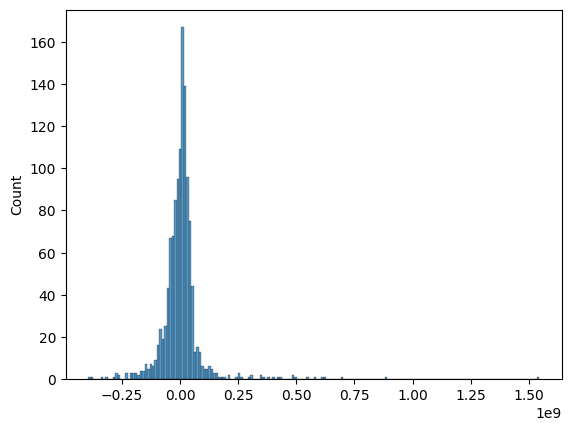

In [29]:
# first calculate residuals 
resid = y_test - test_preds

# Create a Q-QPlot
sns.histplot(resid);

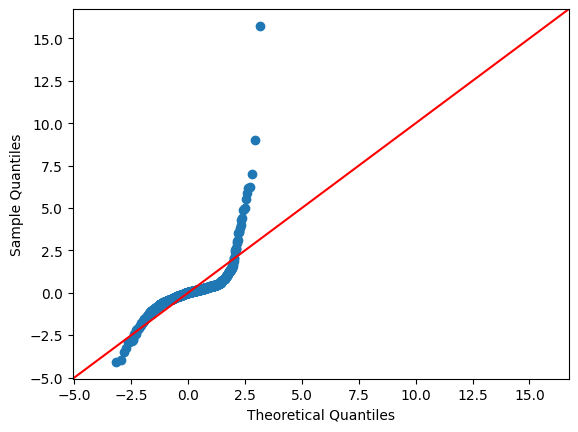

In [30]:
# then use sm's  qqplot
sm.graphics.qqplot(resid, line='45', fit=True);

### Residual Plot for Checking Homoscedasticity

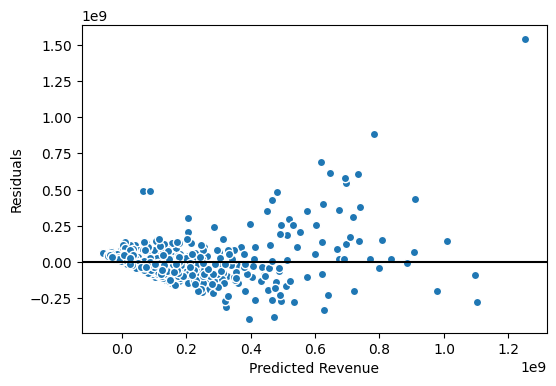

In [31]:
# Plot scatterplot with test_preds vs resids
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(test_preds, resid, ec='white')
ax.axhline(0, color='k')
ax.set(ylabel='Residuals',xlabel='Predicted Revenue');

In [32]:
# Lets put the above graphs into a function so we can reuse for later use
def evaluate_ols(result,X_train_df, y_train):
    """Plots a Q-Q Plot and residual plot for a statsmodels OLS regression."""
    ## save residuals from result
    y_pred = result.predict(X_train_df)
    resid = y_train - y_pred
    
    fig, axes = plt.subplots(ncols=2,figsize=(12,5))
    
    ## Normality 
    sm.graphics.qqplot(resid,line='45',fit=True,ax=axes[0]);
    
    ## Homoscedasticity
    ax = axes[1]
    ax.scatter(y_pred, resid, edgecolor='white',lw=1)
    ax.axhline(0,zorder=0)
    ax.set(ylabel='Residuals',xlabel='Predicted Value');
    plt.tight_layout()

### Checking our Coefficients


In [33]:
# extract the coefficients from model
# suppress scientific notation and add "," sep for 1,000's
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")
result.params

certification_G          35,629,264.86
certification_MISSING    17,161,928.24
certification_NC-17      13,406,723.63
certification_PG         18,060,157.86
certification_PG-13       5,907,322.33
certification_R         -14,043,718.43
certification_UR         10,920,260.82
adult                       374,973.65
belongs_to_collection    23,696,345.87
budget                   76,096,286.46
popularity                7,900,101.51
runtime                   3,287,735.76
vote_average             -2,211,933.61
vote_count               85,223,191.61
year                      4,459,685.59
month                       878,782.08
day                        -524,133.85
const                    87,041,939.31
dtype: float64

# Improving Our Model
 ### Assumption of Linearity

Number of columns :  18


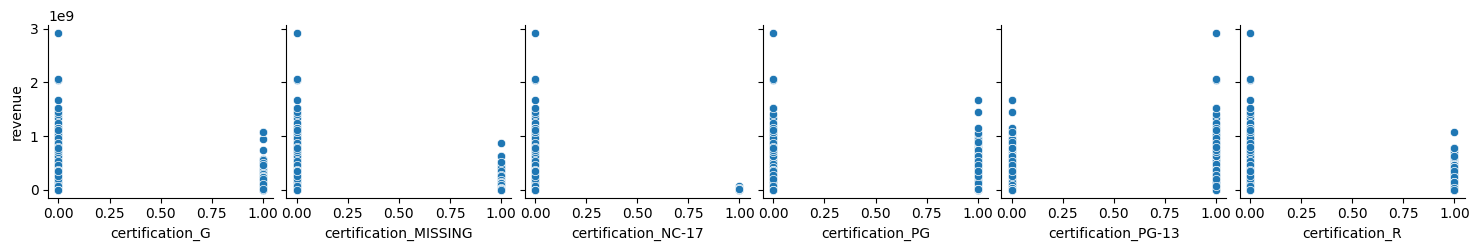

In [34]:
# concatenating training data into a dataframe that we will use for ploting
plot_df = pd.concat([X_train_df,y_train],axis=1)

# save plot_cols list to show (dropping genre from plot_df from pair_plot)
genre_cols = [c for c in df.columns if c.startswith('Genre')]
plot_cols = plot_df.drop(columns=['revenue',*genre_cols]).columns
print("Number of columns : ", len(plot_cols))

sns.pairplot(data=plot_df, y_vars='revenue',x_vars=plot_cols[:6]);

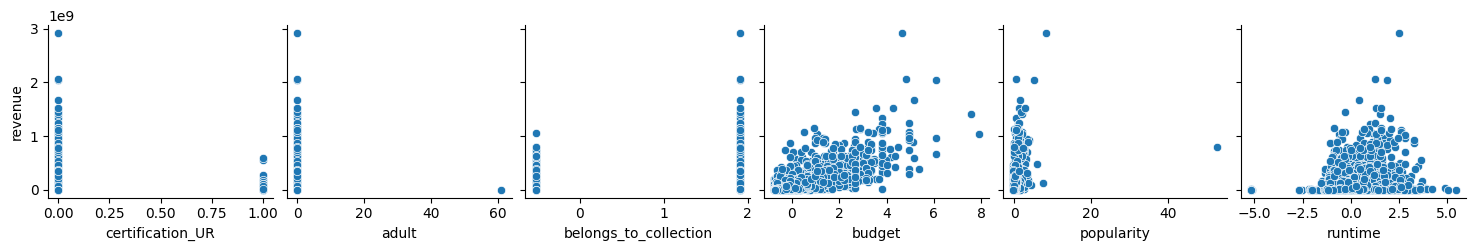

In [35]:
sns.pairplot(data=plot_df, y_vars='revenue',x_vars=plot_cols[6:12]);

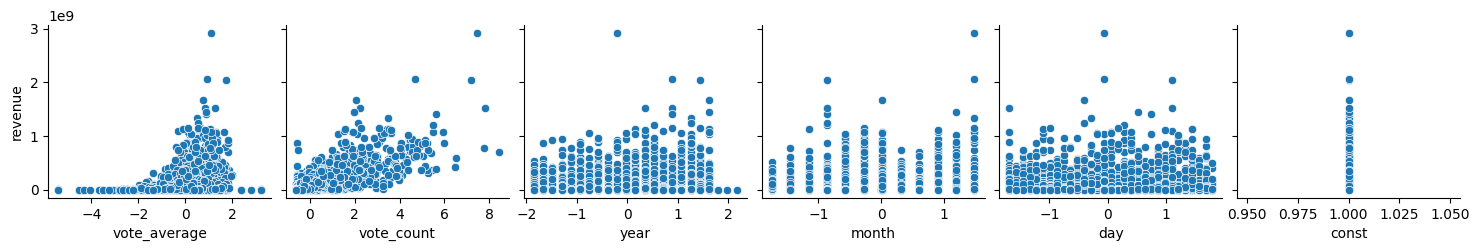

In [36]:
sns.pairplot(data=plot_df, y_vars='revenue',x_vars=plot_cols[12:]);

# Removing Outliers

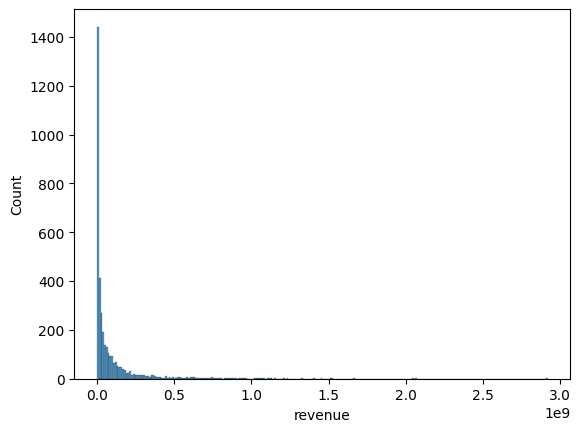

In [37]:
sns.histplot(plot_df['revenue']);

In [38]:
# Define a function that finds the outliers in a specific Series
def find_outliers(data, verbose=True):
    outliers = np.abs(stats.zscore(data))>3
    
    if verbose:
        print(f"- {outliers.sum()} outliers found in {data.name} using Z-Scores.")
    return outliers

In [39]:
# save a dictionary of the T/F outlier index for each feature in outleir_cols
outlier_cols = ['runtime','popularity','revenue']

outliers = {}
for col in outlier_cols:
    outliers_col = find_outliers(df[col])
    outliers[col] = outliers_col

- 64 outliers found in runtime using Z-Scores.
- 27 outliers found in popularity using Z-Scores.
- 127 outliers found in revenue using Z-Scores.


In [40]:
# Make new df_clean copy of df
df_clean = df.copy()

# loop through dictionary to remove outliers
for col, idx_outliers in outliers.items():
    df_clean = df_clean[~idx_outliers]
df_clean

C:\Users\default.DESKTOP-0LDO0LD\AppData\Local\Temp\ipykernel_14680\4144025219.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clean = df_clean[~idx_outliers]


,adult,belongs_to_collection,budget,popularity,revenue,runtime,vote_average,vote_count,certification,year,month,day
4,0.00,False,"150,000.00",22.36,"12,854,953.00",99.00,8.11,"2,009.00",PG,"2,000.00",9.00,29.00
11,0.00,False,"120,000.00",4.26,"14,904.00",87.00,5.40,42.00,R,"2,002.00",4.00,26.00
13,0.00,True,"45,000,000.00",71.99,"224,834,564.00",84.00,6.70,"4,158.00",G,"2,000.00",6.00,21.00
16,0.00,False,"8,000,000.00",13.30,"105,983.00",122.00,5.90,254.00,R,"2,000.00",2.00,9.00
17,0.00,True,"125,000,000.00",36.36,"546,388,105.00",123.00,6.10,"5,508.00",PG-13,"2,000.00",5.00,24.00
...,...,...,...,...,...,...,...,...,...,...,...,...
52607,0.00,True,"1,066,375.00",1.07,"4,165,528.00",140.00,6.00,3.00,NaN,"2,019.00",7.00,19.00
52613,0.00,False,"8,120,000.00",17.75,"124,652,206.00",111.00,7.08,176.00,NaN,"2,019.00",1.00,23.00
52636,0.00,False,"3,500,000.00",4.00,"10,000,000.00",149.00,4.57,7.00,NaN,"2,019.00",12.00,13.00
52851,0.00,False,"12,547,000.00",3.33,"1,091,477.00",116.00,6.82,11.00,NaN,"2,019.00",2.00,27.00


In [41]:
## REPEAT PREPROCESSING CODE
## Make x and y variables
y = df_clean['revenue']
X = df_clean.drop(columns=['revenue'])

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=321)
X_train

# make X_train_df
preprocessor.fit(X_train)
final_features = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame( preprocessor.transform(X_train), 
                          columns=final_features, index=X_train.index)

X_test_df = pd.DataFrame( preprocessor.transform(X_test), 
                         columns=final_features, index=X_test.index)

## Make final X_train_df and X_test_df with constants added
X_train_df = sm.add_constant(X_train_df, has_constant='add')
X_test_df = sm.add_constant(X_test_df, has_constant='add')
display(X_test_df.head(), X_train_df.head())

,const,certification_G,certification_MISSING,certification_NC-17,certification_PG,certification_PG-13,certification_R,certification_UR,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,belongs_to_collection
11812,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.02,0.24,-0.39,-1.47,-1.26,-0.51,-0.38,-0.24,1.13,1.00
49557,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,-0.02,-0.75,-0.74,-0.67,1.75,-0.61,1.63,1.51,1.36,0.00
34084,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,-0.02,-0.79,-0.66,-1.96,0.22,-0.61,1.08,-1.70,0.78,0.00
10217,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,-0.02,-0.24,0.03,-0.19,0.38,0.52,-0.56,-0.83,-0.39,0.00
40682,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,-0.02,-0.51,0.08,-0.67,0.90,0.70,1.27,-0.53,0.31,0.00


,const,certification_G,certification_MISSING,certification_NC-17,certification_PG,certification_PG-13,certification_R,certification_UR,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,belongs_to_collection
41226,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,-0.02,-0.68,-0.45,-0.99,-0.14,-0.59,1.27,-1.70,0.43,0.00
8381,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,-0.02,-0.43,-0.32,0.67,1.10,-0.11,-0.75,-1.12,0.19,0.00
12331,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.02,-0.10,-0.55,-1.37,-0.63,-0.52,-0.38,-1.12,-0.97,0.00
38207,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,-0.02,-0.79,-0.79,1.95,0.98,-0.64,1.08,-0.83,-0.86,0.00
39593,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,-0.02,-0.26,-0.16,0.13,-0.50,0.14,1.27,0.63,1.48,0.00


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     755.8
Date:                Thu, 10 Nov 2022   Prob (F-statistic):               0.00
Time:                        17:16:14   Log-Likelihood:                -68589.
No. Observations:                3575   AIC:                         1.372e+05
Df Residuals:                    3558   BIC:                         1.373e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  5.904e+07   2.33e+06     25.334      0.000    5.45e+07    6.36e+07
certification_G        2.464e+07   6.42e+06      3.837      0.000    1.21e+07    3.72e+07
certification_MISSING  8.857e+06   2.87e+06      3.087      0.002    3.23e+06    1.45e+07
certification_NC-17    5.773e+06   1.38e+07      0.418      0.676   -2.13e+07    3.29e+07
certification_PG        2.36e+07   3.41e+06      6.929      0.000    1.69e+07    3.03e+07
certification_PG-13    5.171e+06   2.76e+06      1.876      0.061   -2.34e+05    1.06e+07
certification_R       -1.117e+07   2.64e+06     -4.225      0.000   -1.63e+07   -5.98e+06
certification_UR       2.153e+06    4.9e+06      0.439      0.660   -7.46e+06    1.18e+07
adult                  1.797e+04   8.73e+05      0.021      0.984   -1.69e+06    1.73e+06
budget                 4.757e+07   1.17e+06     40.795      0.000    4.53e+07    4.99e+07
popularity             8.328e+06    1.2e+06      6.922      0.000    5.97e+06    1.07e+07
runtime                2.256e+05   9.64e+05      0.234      0.815   -1.67e+06    2.12e+06
vote_average          -3.737e+04   9.69e+05     -0.039      0.969   -1.94e+06    1.86e+06
vote_count             4.829e+07   1.28e+06     37.745      0.000    4.58e+07    5.08e+07
year                  -6.488e+05   8.98e+05     -0.722      0.470   -2.41e+06    1.11e+06
month                   2.54e+05   8.77e+05      0.290      0.772   -1.46e+06    1.97e+06
day                   -4.914e+05   8.74e+05     -0.562      0.574    -2.2e+06    1.22e+06
belongs_to_collection  3.591e+07   2.33e+06     15.409      0.000    3.13e+07    4.05e+07
==============================================================================
Omnibus:                     1106.048   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10005.628
Skew:                           1.208   Prob(JB):                         0.00
Kurtosis:                      10.832   Cond. No.                     1.70e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.83e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

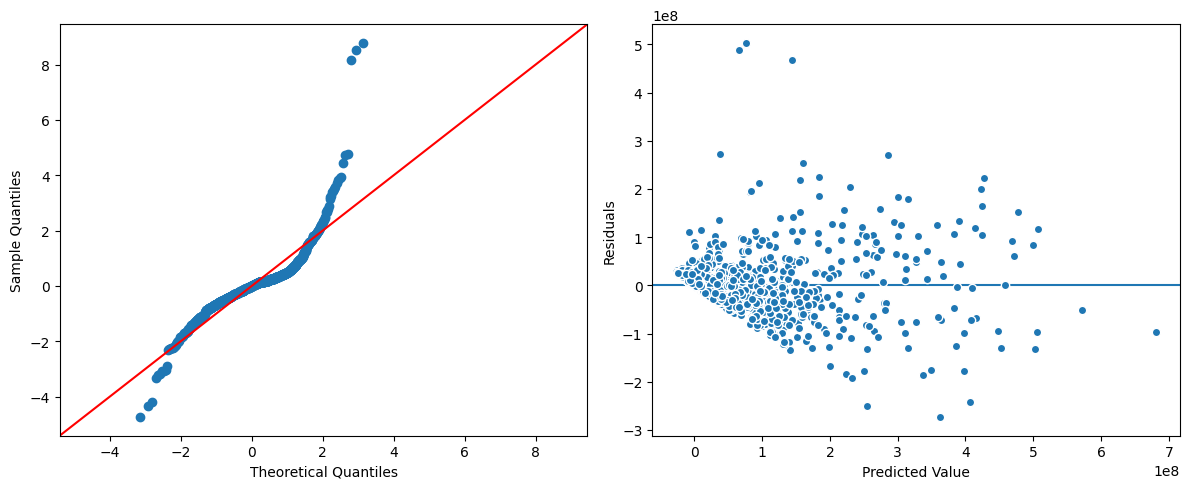

In [42]:
## instantiate an OLS model WITH the training data.
model = sm.OLS(y_train, X_train_df)

## Fit the model and view the summary
result = model.fit()

evaluate_ols(result,X_test_df,y_test)

result.summary()

# Addressing Multicollinearity

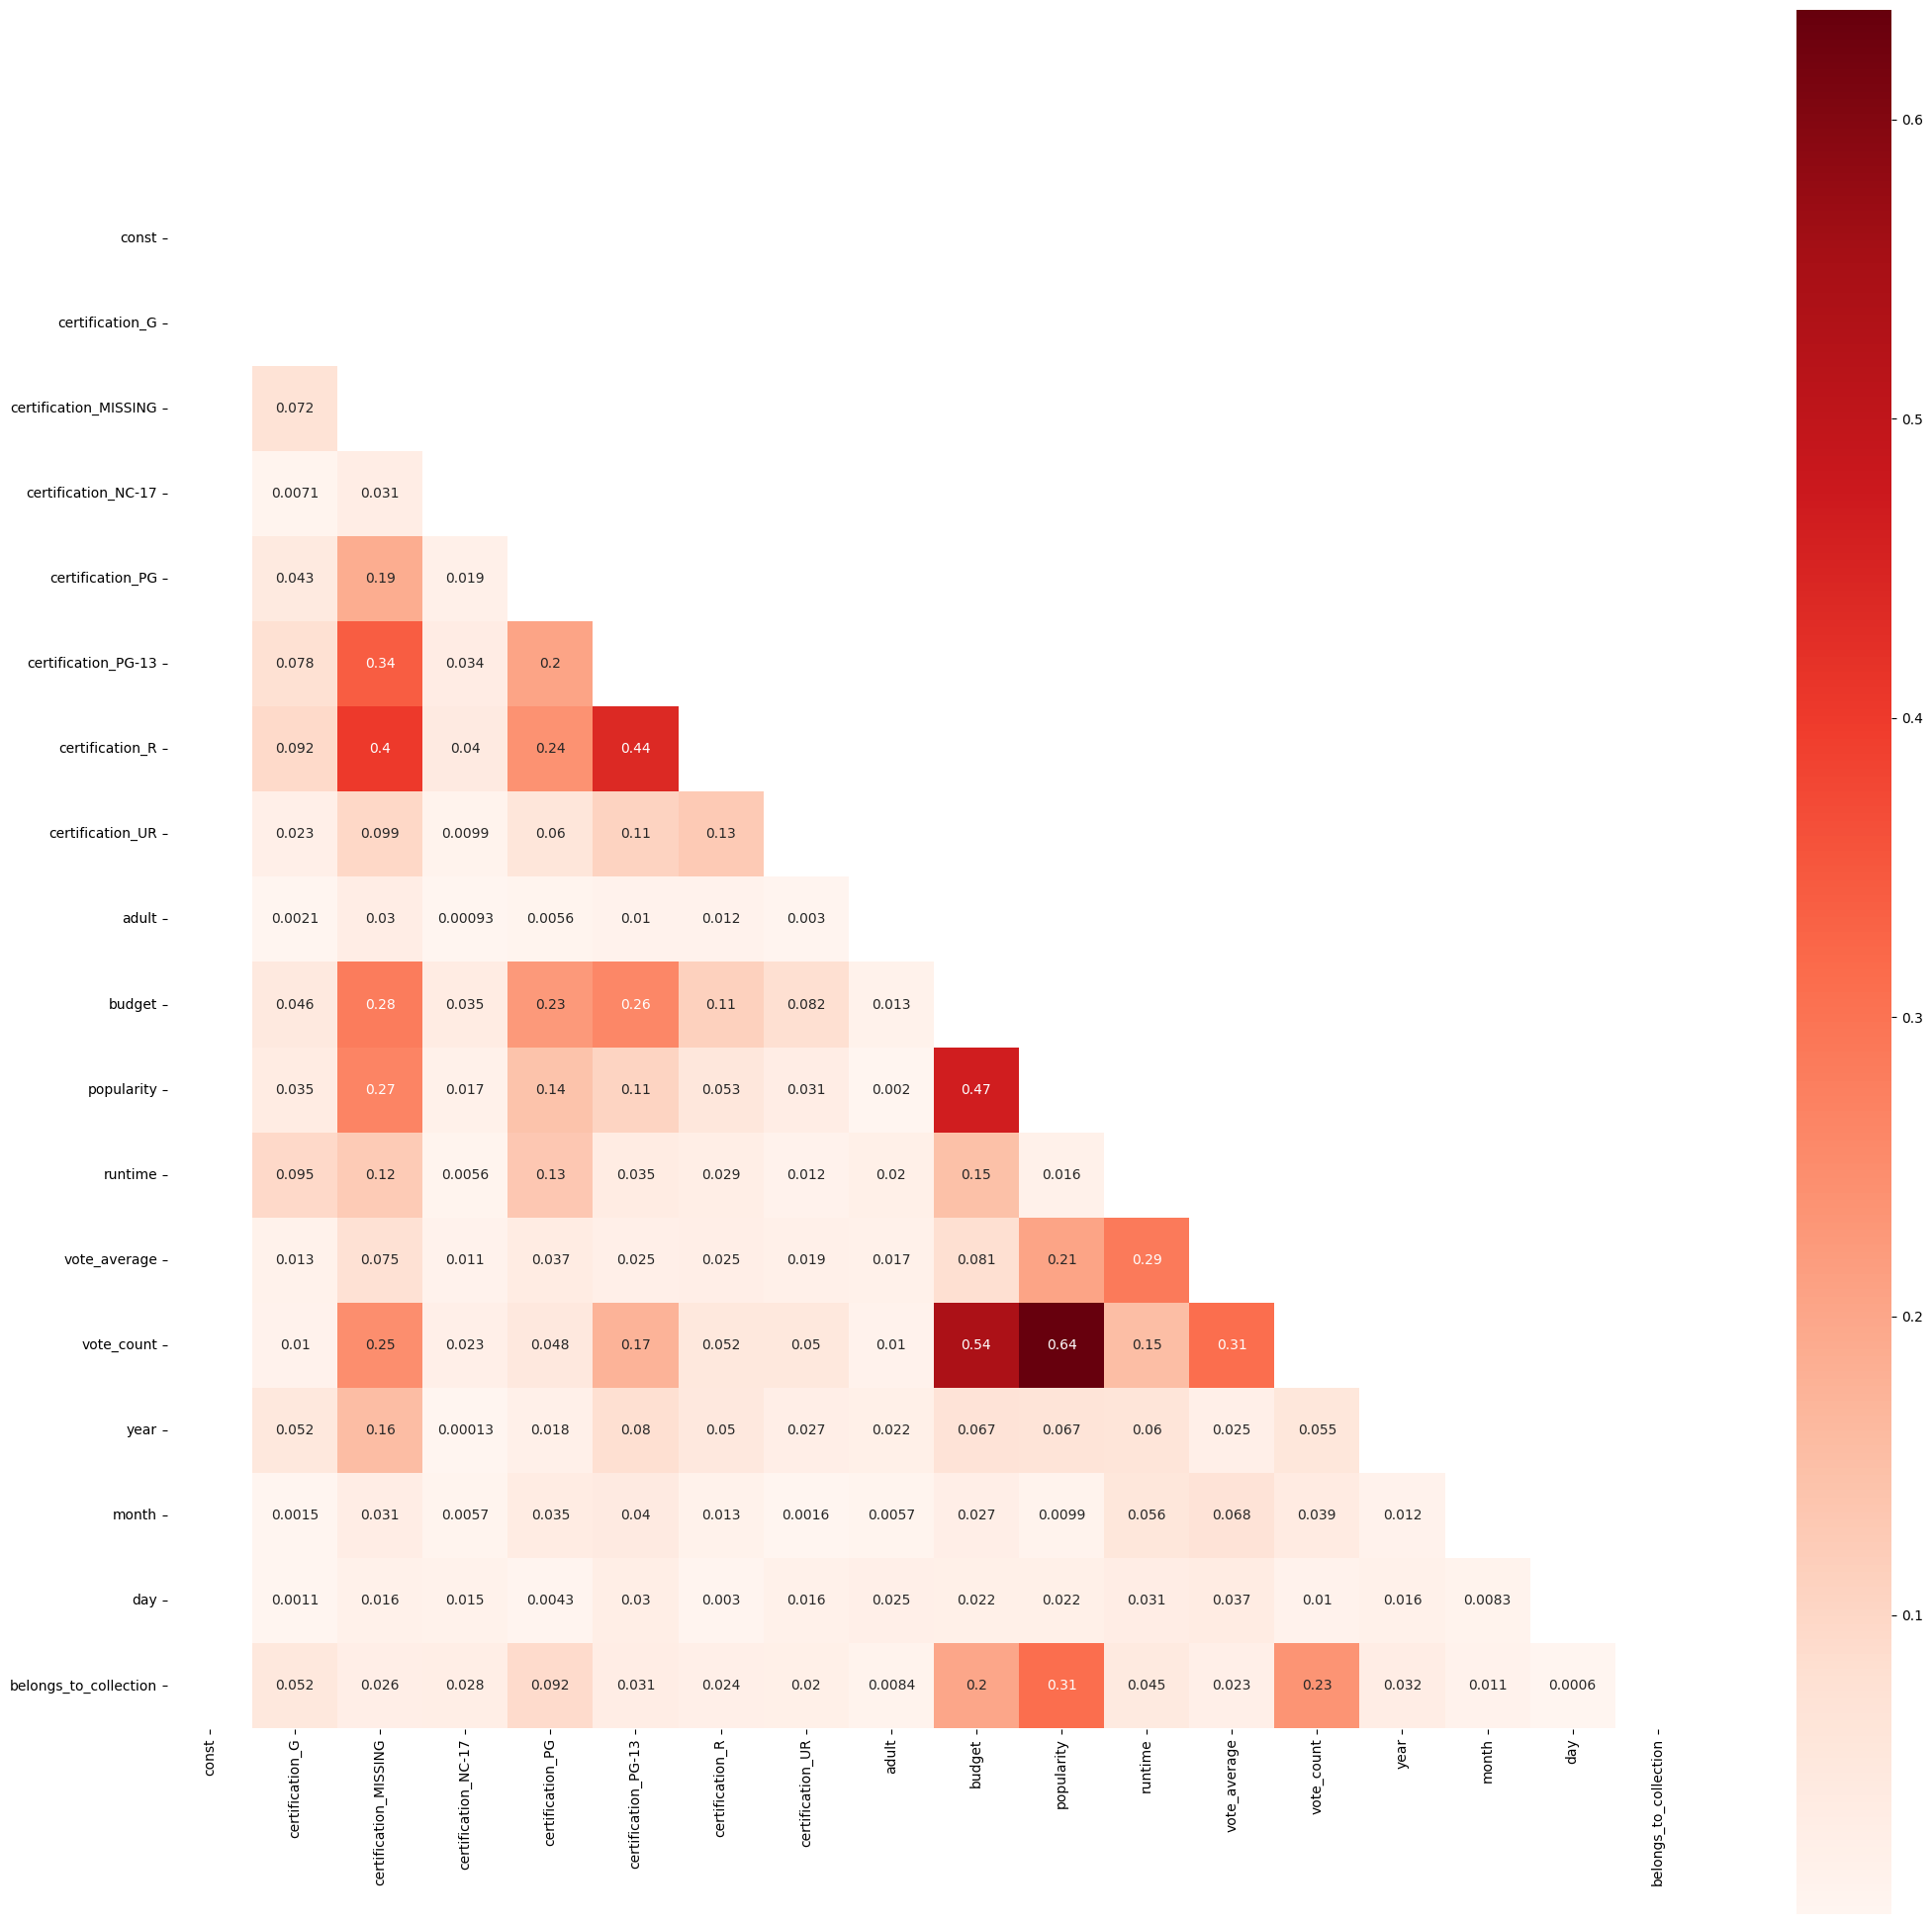

In [43]:
# Calculating the mask to hide the upper-right of the triangle
plt.figure(figsize=(25,25))
corr = X_train_df.corr().abs()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr,square=True, cmap='Reds', annot=True, mask=mask);

# Variance Inflation Factor

In [44]:
# separate just x-data and subtract mean
features = X_train_df - X_train_df.mean()

# create a list of VIF scores for each feature in features.
vif_scores = [variance_inflation_factor(features.values, i) for i in range(len(features.columns))]

# create a new dataframe to hold the VIF scores 
VIF = pd.Series(vif_scores, index=features.columns)

# Sort VIF for inspection
print("Sorted VIF WITH infinite values\n", VIF.sort_values())

# Getting a lot of infinite values, is this ok?

## remove infinite values from VIF and sort
VIF = VIF[VIF!=np.inf].sort_values()
print("\n\nSorted VIF WITHOUT infinite values\n", VIF)

Sorted VIF WITH infinite values
 adult                   1.00
day                     1.00
month                   1.01
year                    1.06
belongs_to_collection   1.14
runtime                 1.22
vote_average            1.23
budget                  1.79
popularity              1.90
vote_count              2.15
certification_R          inf
certification_PG-13      inf
certification_PG         inf
certification_NC-17      inf
certification_MISSING    inf
certification_UR         inf
certification_G          inf
const                    NaN
dtype: float64


Sorted VIF WITHOUT infinite values
 adult                   1.00
day                     1.00
month                   1.01
year                    1.06
belongs_to_collection   1.14
runtime                 1.22
vote_average            1.23
budget                  1.79
popularity              1.90
vote_count              2.15
const                    NaN
dtype: float64


C:\Users\default.DESKTOP-0LDO0LD\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\regression\linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\default.DESKTOP-0LDO0LD\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [45]:
## filter for VIF that are > 5
VIF[VIF>5]

high_vif = VIF[VIF>5].index
high_vif

# Nothing showing up? may be due to previous issues with genre.

Index([], dtype='object')

# Final Model

In [46]:
df_final = df_clean.drop(columns='certification')
df_final

# Why are we dropping the certification column?

,adult,belongs_to_collection,budget,popularity,revenue,runtime,vote_average,vote_count,year,month,day
4,0.00,False,"150,000.00",22.36,"12,854,953.00",99.00,8.11,"2,009.00","2,000.00",9.00,29.00
11,0.00,False,"120,000.00",4.26,"14,904.00",87.00,5.40,42.00,"2,002.00",4.00,26.00
13,0.00,True,"45,000,000.00",71.99,"224,834,564.00",84.00,6.70,"4,158.00","2,000.00",6.00,21.00
16,0.00,False,"8,000,000.00",13.30,"105,983.00",122.00,5.90,254.00,"2,000.00",2.00,9.00
17,0.00,True,"125,000,000.00",36.36,"546,388,105.00",123.00,6.10,"5,508.00","2,000.00",5.00,24.00
...,...,...,...,...,...,...,...,...,...,...,...
52607,0.00,True,"1,066,375.00",1.07,"4,165,528.00",140.00,6.00,3.00,"2,019.00",7.00,19.00
52613,0.00,False,"8,120,000.00",17.75,"124,652,206.00",111.00,7.08,176.00,"2,019.00",1.00,23.00
52636,0.00,False,"3,500,000.00",4.00,"10,000,000.00",149.00,4.57,7.00,"2,019.00",12.00,13.00
52851,0.00,False,"12,547,000.00",3.33,"1,091,477.00",116.00,6.82,11.00,"2,019.00",2.00,27.00


In [47]:
# Make x and y variables
y = df_final['revenue']
X = df_final.drop(columns=['revenue'])

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=321)
X_train

# make X_train_df
preprocessor.fit(X_train)
final_features = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame( preprocessor.transform(X_train), columns=final_features, index=X_train.index)

X_test_df = pd.DataFrame( preprocessor.transform(X_test), columns=final_features, index=X_test.index)

## Make final X_train_df and X_test_df with constants added
X_train_df = sm.add_constant(X_train_df, has_constant='add')
X_test_df = sm.add_constant(X_test_df, has_constant='add')
display(X_test_df.head(), X_train_df.head())

,const,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,belongs_to_collection
11812,1.00,-0.02,0.24,-0.39,-1.47,-1.26,-0.51,-0.38,-0.24,1.13,1.00
49557,1.00,-0.02,-0.75,-0.74,-0.67,1.75,-0.61,1.63,1.51,1.36,0.00
34084,1.00,-0.02,-0.79,-0.66,-1.96,0.22,-0.61,1.08,-1.70,0.78,0.00
10217,1.00,-0.02,-0.24,0.03,-0.19,0.38,0.52,-0.56,-0.83,-0.39,0.00
40682,1.00,-0.02,-0.51,0.08,-0.67,0.90,0.70,1.27,-0.53,0.31,0.00


,const,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,belongs_to_collection
41226,1.00,-0.02,-0.68,-0.45,-0.99,-0.14,-0.59,1.27,-1.70,0.43,0.00
8381,1.00,-0.02,-0.43,-0.32,0.67,1.10,-0.11,-0.75,-1.12,0.19,0.00
12331,1.00,-0.02,-0.10,-0.55,-1.37,-0.63,-0.52,-0.38,-1.12,-0.97,0.00
38207,1.00,-0.02,-0.79,-0.79,1.95,0.98,-0.64,1.08,-0.83,-0.86,0.00
39593,1.00,-0.02,-0.26,-0.16,0.13,-0.50,0.14,1.27,0.63,1.48,0.00


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     1145.
Date:                Thu, 10 Nov 2022   Prob (F-statistic):               0.00
Time:                        17:16:18   Log-Likelihood:                -68666.
No. Observations:                3575   AIC:                         1.374e+05
Df Residuals:                    3564   BIC:                         1.374e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  6.123e+07   1.01e+06     60.788      0.000    5.93e+07    6.32e+07
adult                  1.572e+05   8.91e+05      0.176      0.860   -1.59e+06     1.9e+06
budget                 5.082e+07   1.11e+06     45.945      0.000    4.86e+07     5.3e+07
popularity             7.966e+06   1.22e+06      6.552      0.000    5.58e+06    1.04e+07
runtime               -6.547e+05   9.51e+05     -0.688      0.491   -2.52e+06    1.21e+06
vote_average           6.306e+05   9.82e+05      0.642      0.521   -1.29e+06    2.56e+06
vote_count             4.594e+07   1.29e+06     35.706      0.000    4.34e+07    4.85e+07
year                   1.674e+05   9.03e+05      0.185      0.853    -1.6e+06    1.94e+06
month                  5.888e+05   8.93e+05      0.659      0.510   -1.16e+06    2.34e+06
day                   -5.399e+05   8.92e+05     -0.606      0.545   -2.29e+06    1.21e+06
belongs_to_collection  3.781e+07   2.36e+06     16.042      0.000    3.32e+07    4.24e+07
==============================================================================
Omnibus:                     1129.581   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9928.141
Skew:                           1.248   Prob(JB):                         0.00
Kurtosis:                      10.773   Cond. No.                         4.12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

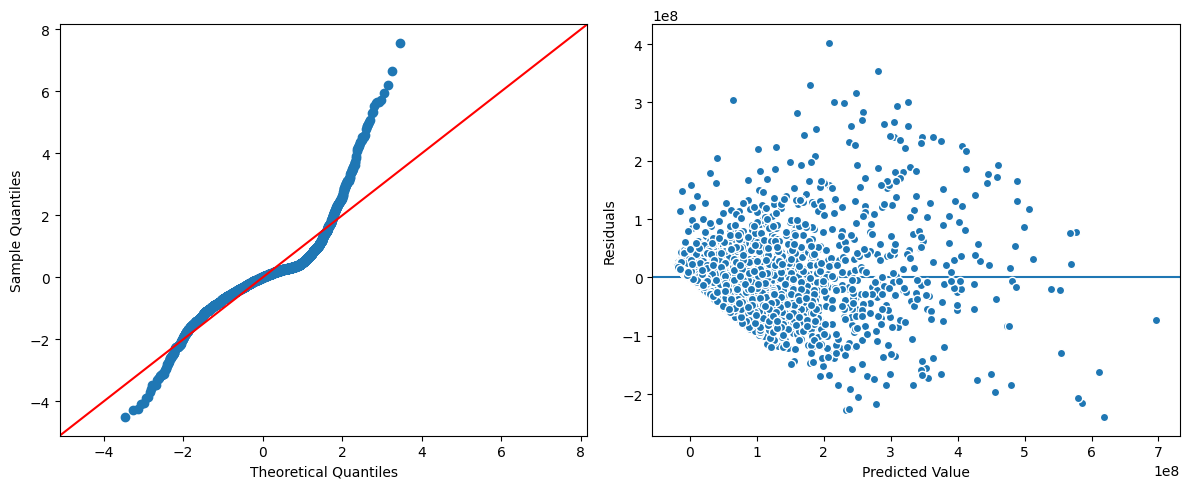

In [48]:
## instantiate an OLS model WITH the training data.
model = sm.OLS(y_train, X_train_df)

## Fit the model and view the summary
result = model.fit()

evaluate_ols(result,X_train_df,y_train)

result.summary()

In [49]:
result.params

const                   61,225,816.47
adult                      157,161.95
budget                  50,815,263.38
popularity               7,966,087.45
runtime                   -654,683.89
vote_average               630,556.93
vote_count              45,935,140.73
year                       167,428.87
month                      588,790.39
day                       -539,928.40
belongs_to_collection   37,809,329.10
dtype: float64

In [ ]:
# Is there anything else that i've missed?